# Heart Rate Filtering

Knowing an athlete's heart rate maximum is essential to identify portions of their ride in which Heart Rate Recovery (30) can be calculated. Since the athlete's self-reported age as stored on the Golden Cheetah database has been found to be unreliable, we have to rely on the heart-rate data from each ride to identify each athlete's maximum. The challenge we face here is that simply selecting the maximum heart rate value for an athlete's data might not be accurate. We suspect some of these really high heart rate values to be instrument errors. Therefore, the need arises to apply a filter to the heart rate data from each ride before identifying the maximum value. 

This notebook applies the median_filter and the Hamel filter to an athlete's data that we know has extremely high heart rate values that are likely erroneous. 

In [1]:
import os

# Print current working directory
print(f"The current working directory is: {os.getcwd()}")

# Change the current working directory to the parent directory
os.chdir("..")

# Print current working directory
print(f"The current working directory is: {os.getcwd()}")

The current working directory is: c:\Users\karka\Projects\Golden-Cheetah\notebooks
The current working directory is: c:\Users\karka\Projects\Golden-Cheetah


In [2]:
# Importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from opendata import OpenData  # Golden Cheetah python library

In [3]:
od = OpenData()

In [4]:
# Accessing data for the sample athlete (2e99)

athlete = od.get_remote_athlete("0066cbd9-2072-472f-8018-2e320f0b2e99")
activities = list(athlete.activities())

In [5]:
# Choosing an activity which we know has an extremely high heart rate (249 bpm)
activity = activities[1693].data

<Axes: title={'center': 'Original Heart Rate Data'}, xlabel='Time (seconds)', ylabel='Heart Rate (bpm)'>

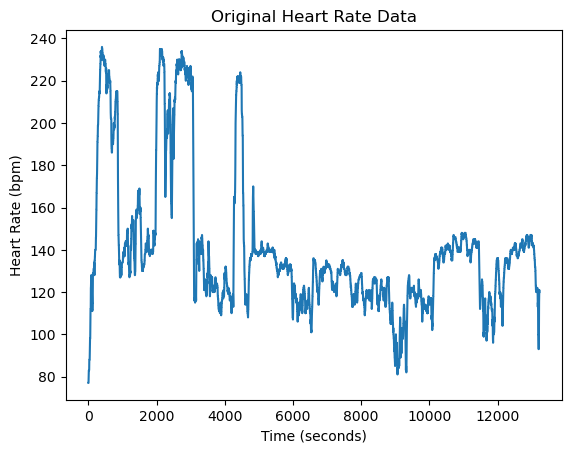

In [6]:
# Plotting the original heart rate data
activity["hr"].plot(
    title="Original Heart Rate Data", xlabel="Time (seconds)", ylabel="Heart Rate (bpm)"
)

In [7]:
# Data description of original heart rate data

activity["hr"].describe()

count    13225.000000
mean       140.769414
std         33.997304
min         77.000000
25%        119.000000
50%        133.000000
75%        143.000000
max        236.000000
Name: hr, dtype: float64

## Median Filter

In this section, I will apply the *scipy.ndimage.median_filter* to the heart rate data and compare the filtered data to the original.

In [8]:
# Importing packages

from scipy.ndimage import median_filter

In [9]:
# Converting the heart rate data to a numpy array

hr_array = activity["hr"].to_numpy()

In [10]:
# Applying the median filter to the heart rate array

hr_array_filtered = median_filter(hr_array, size=61)

In [11]:
# Adding filtered heart rate data to the activity dataframe

activity["hr_med_filter"] = pd.Series(hr_array_filtered)

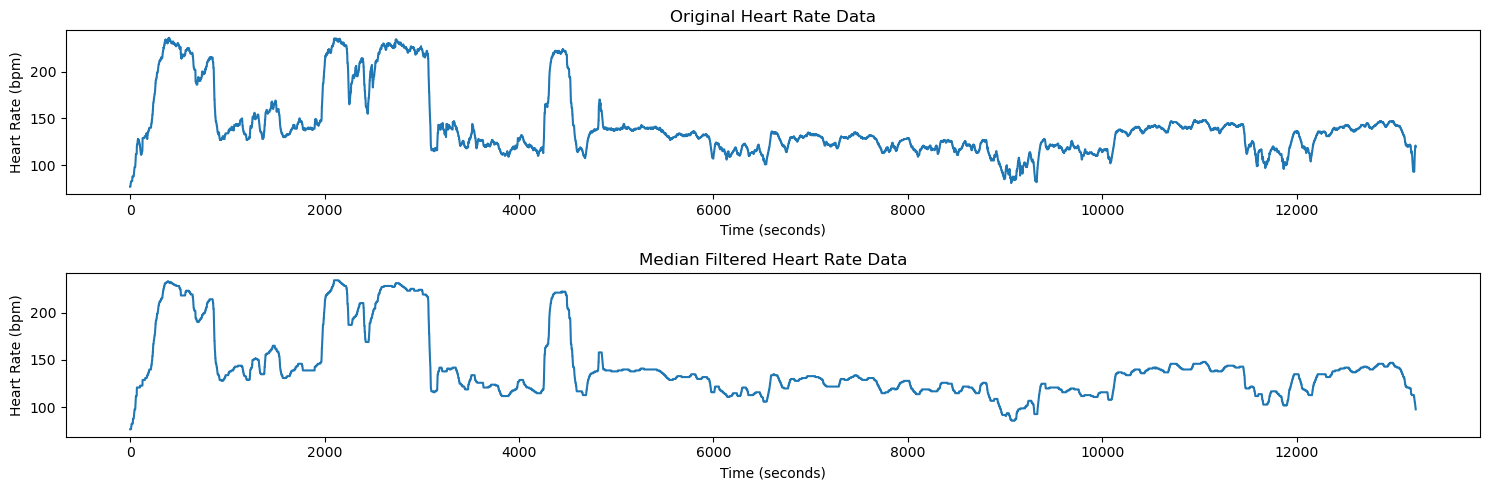

In [12]:
# Plotting original and filtered heart rate data for comparison.

fig, ax = plt.subplots(2, 1, figsize=(15, 5))

activity["hr"].plot(
    title="Original Heart Rate Data",
    xlabel="Time (seconds)",
    ylabel="Heart Rate (bpm)",
    ax=ax[0],
)

activity["hr_med_filter"].plot(
    title="Median Filtered Heart Rate Data",
    xlabel="Time (seconds)",
    ylabel="Heart Rate (bpm)",
    ax=ax[1],
)

plt.tight_layout()
plt.show()


In [13]:
# Data description of filtered heart rate data

activity["hr_med_filter"].describe()

count    13225.000000
mean       140.890926
std         33.855078
min         77.000000
25%        120.000000
50%        133.000000
75%        142.000000
max        234.000000
Name: hr_med_filter, dtype: float64

In [14]:
activity.head()

,secs,km,power,hr,cad,alt,hr_med_filter
0,0,0.0000,0.0,77.0,33.0,526.4,77.0
1,1,0.0032,67.0,77.0,34.0,526.4,77.0
2,2,0.0068,79.0,77.0,34.0,526.0,77.0
3,3,0.0110,85.0,78.0,42.0,525.8,77.0
4,4,0.0152,40.0,79.0,52.0,525.6,77.0


## Hampel Filter

In this section, I will apply the *HampelFilter* from SkTime to the heart rate data and compare the filtered data to the original.

In [15]:
# Importing packages

from sktime.transformations.series.outlier_detection import HampelFilter
from sktime.transformations.series.impute import Imputer

In [16]:
# Converting the heart rate data to a numpy array

hr_array = activity["hr"]

In [17]:
# Applying the Hampel filter to the heart rate array

hr_array_filtered = HampelFilter().fit_transform(hr_array)

In [18]:
# Imputing nan values in the "hr_hampel_filter" column using the backfill method

hr_array_filtered = Imputer(method="linear").fit_transform(hr_array_filtered)

In [19]:
# Adding filtered heart rate data to the activity dataframe

activity["hr_hampel_filter"] = pd.Series(hr_array_filtered)

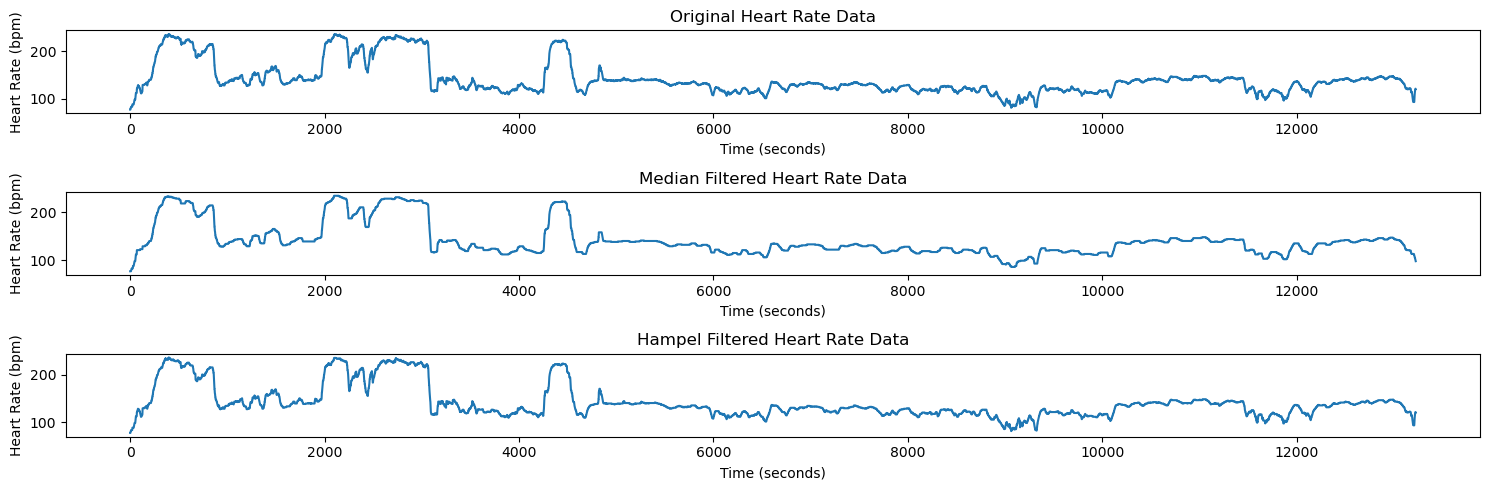

In [20]:
# Plotting original, median filtered and Hampel filtered heart rate data for comparison.

fig, ax = plt.subplots(3, 1, figsize=(15, 5))

activity["hr"].plot(
    title="Original Heart Rate Data",
    xlabel="Time (seconds)",
    ylabel="Heart Rate (bpm)",
    ax=ax[0],
)

activity["hr_med_filter"].plot(
    title="Median Filtered Heart Rate Data",
    xlabel="Time (seconds)",
    ylabel="Heart Rate (bpm)",
    ax=ax[1],
)

activity["hr_hampel_filter"].plot(
    title="Hampel Filtered Heart Rate Data",
    xlabel="Time (seconds)",
    ylabel="Heart Rate (bpm)",
    ax=ax[2],
)

plt.tight_layout()
plt.show()

The above figure shows that the Hampel filter does not transform the data much, but the median filter, with a fairly large window size, smooths the data. Neither method does anything to the extremely high heart rate values. This is because the high heart rate values are not just point errors but are present for an extended period. It is difficult to ascertain whether this is a systematic instrument error or whether the athlete actually achieved these heart rate values. 

In [21]:
# Saving the filtered heart rate data to a csv file

activity.to_csv(r"data\external\2e99_activity.csv", index=False)

# Identifying HR Max of shortlisted female athletes

In this section, I will apply the hr_max function to the 35 female athletes within *data\interim\athletes_overview_filtered.csv* and create a dateaframe for each.

In [22]:
# Importing hr_max function from the data module
from src.data import hr_max

In [23]:
# Importing the data

df = pd.read_csv("data/interim/athletes_overview_filtered.csv")

# Printing the first few rows of the dataframe
df.head()

,id,gender,yob,numberOfRides,duration,rideFrequency
0,000c6417-e1e4-497e-89e6-bb21e17ec355,M,1998,394,649,0.607088
1,0031326c-e796-4f35-8f25-d3937edca90f,M,2062,670,642,1.043614
2,004d4e6e-2a19-4876-975e-9f23e9e907fc,M,2071,1265,1641,0.770871
3,009d7d63-35df-4924-8b40-4244832a50e1,M,1982,1483,2230,0.665022
4,01843f3a-8883-4a76-a60f-223c92ff7ef1,F,1982,167,329,0.507599


In [24]:
df_females = df[df["gender"] == "F"].reset_index(drop=True)

df_females.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             35 non-null     object 
 1   gender         35 non-null     object 
 2   yob            35 non-null     int64  
 3   numberOfRides  35 non-null     int64  
 4   duration       35 non-null     int64  
 5   rideFrequency  35 non-null     float64
dtypes: float64(1), int64(3), object(2)
memory usage: 1.8+ KB


In [ ]:
# Applying hr_max function to all shortlisted females

import multiprocessing

# Get a list of all athlete IDs in the dataset
athletes_series = df_females["id"]

# Create a pool of worker processes
with multiprocessing.Pool() as pool:
    # Apply hr_max to each athlete using the pool
    max_hr_list = pool.map(hr_max, athletes_series)

# Output the results
df_females["max_hr"] = max_hr_list

In [ ]:
df_females.head()

In [28]:
df_females.to_csv(r"data\interim\df_females.csv", index=False)

# Selecting Males from the Filtered Dataframe

In this section, I will select 40 males at random from the filtered dataframe. I will apply the hr_max() function to them. Once I filter out any males with extremely high heart rates, I will choose 25 for further analysis. 

In [ ]:
# Isolating males
df_males = df[df["gender"] == "M"].reset_index(drop=True)

In [ ]:
# Taking a sample of 40 athletes from df_males

df_males_sample = df_males.sample(n=40, random_state=42)

In [ ]:
# Applying hr_max function to all males in the sample

# Get a list of all athlete IDs in the dataset
athletes_series = df_males_sample["id"]

# Create a pool of worker processes
with multiprocessing.Pool() as pool:
    # Apply hr_max to each athlete using the pool
    max_hr_list = pool.map(hr_max, athletes_series)

# Output the results
df_males_sample["max_hr"] = max_hr_list

In [ ]:
# Saving df_males_sample to csv as df_males

df_males_sample.to_csv(r"data\interim\df_males.csv", index=False)
